# **1-2 금융 데이터와 전처리**

## **6 <span style="color:orange">Log 가격정보</span> 를 활용한 자산 수익의 정형화된 사실의 조사**
**정형화된 사실(Styled fact)** 에서는 **경험적 자산 수익률** 에서 나타나는 **통계적 분석 속성** 을 분석 합니다
- ! pip install statsmodels

## **01 Reading the Stock DataSet**

In [1]:
DATA_FILENAME = 'data/stock-samsung.pkl'
import pandas as pd
data_stock = pd.read_pickle(DATA_FILENAME)
data_stock.head(3)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-01-04,1776,1776,1624,1693,666160,0.095084
1999-01-05,1692,1712,1649,1673,643209,-0.011813
1999-01-06,1702,1720,1651,1718,645110,0.026898


In [2]:
import numpy as np
df = data_stock.loc[:, ['Close']]  # DataFrame 으로 데이터 추출
df.rename(columns={'Close':'adj_close'}, inplace=True)

# 추가 수익률 계산내용의 추가
df['simple_rtn'] = df.adj_close.pct_change()                  # 단순 수익률 계산 (자산기준 수익률 가중화 합산)
df['log_rtn'] = np.log(df.adj_close / df.adj_close.shift(1))  # Log 수익률 계산 (시간에 따른 수익률 log 합산)
df = df.dropna()
df.head(3)

,adj_close,simple_rtn,log_rtn
Date,,,
1999-01-05,1673,-0.011813,-0.011884
1999-01-06,1718,0.026898,0.026542
1999-01-07,1841,0.071595,0.069148


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager as fm

plt.style.use('seaborn') # 'seaborn-colorblind'
plt.rc('axes', unicode_minus=False)
warnings.simplefilter(action='ignore', category=FutureWarning)
font_list_check  = ['D2Coding', 'NanumGothicCoding', 'NanumGothic']

for font in font_list_check:
    font_counts = [ f  for f in font_list_check 
        if font in [_.name for _ in fm.ttflist]]
    if len(font_counts) > 1: 
        print(f"found : {font}"); break
        
# 폰트 적용하기
plt.rc('font', family=font)        

found : D2Coding


## **02 정규 분포 확률 밀도 함수 (PDF)**
- Probability Density Function 를 계산하고
- 위 결과값을 **히스토그램** 과 **Q-Q** 도면을 출력한다
- Log 수익률 데이터의 정규성을 평가 **(요약 통계량)** 한다 (P-value 가 0으로 귀무가설이 기각된다)

In [4]:
# 관측한 수익률의 평균과 표준편차를 계산하여, 
# 정규분포 확률 밀도함수 (Probability Density Function) 을 계산한다
import scipy.stats as scs
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

/home/buffet/Coding/Python/Nlpy/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


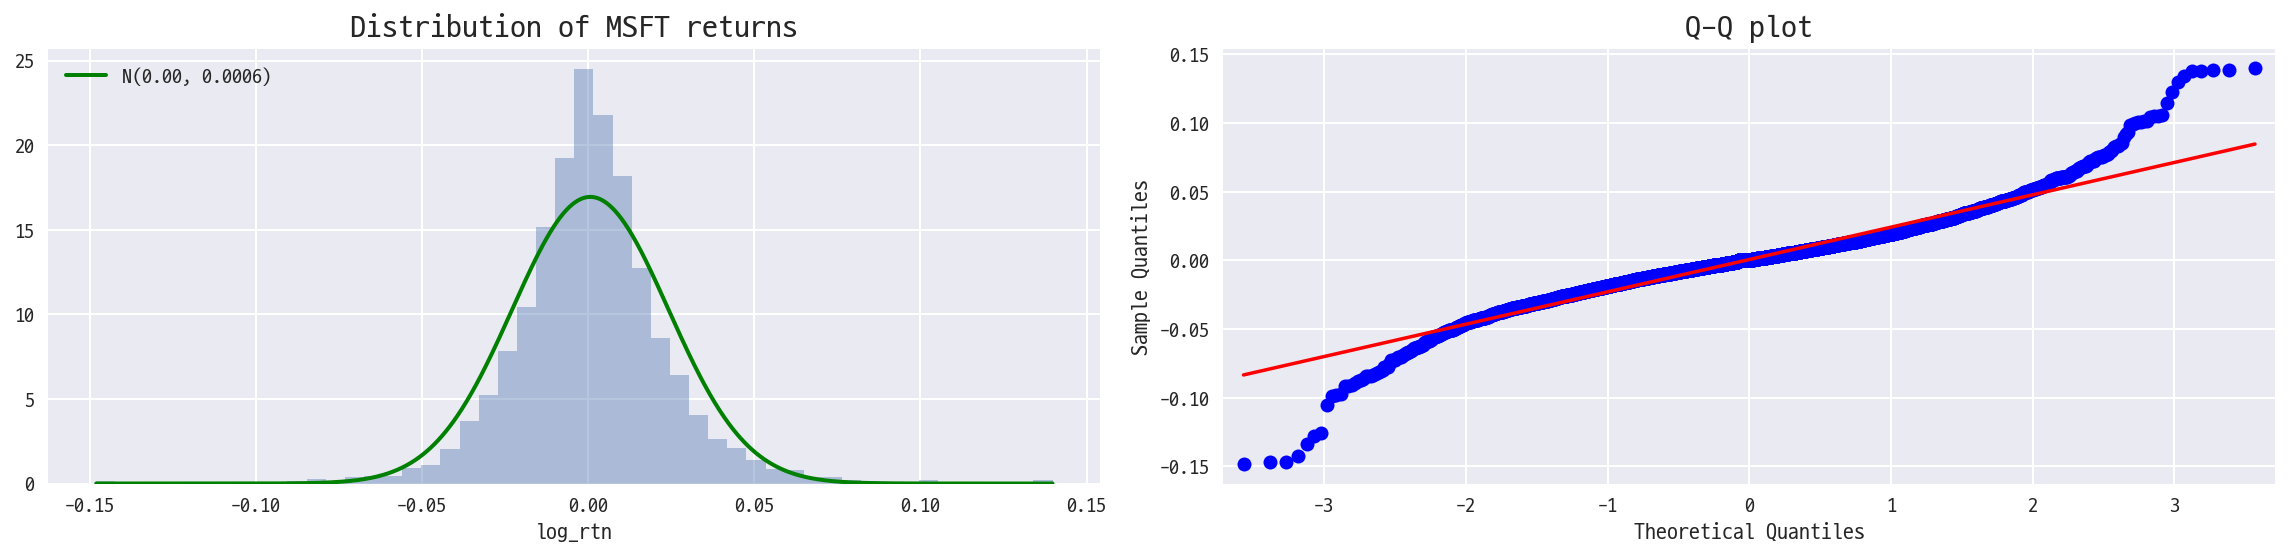

In [5]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Histogram 그리기
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])                                    
ax[0].set_title('Distribution of MSFT returns', fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, 'g', lw=2, 
           label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot 그리기
import statsmodels.api as sm
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)
# plt.savefig('images/ch1_im10.png')
plt.tight_layout(); plt.show()

In [6]:
# 통계적인 방법을 활용하여 
# Log 수익률 데이터의 정규성 검정을 실시한다
jb_test = scs.jarque_bera(df.log_rtn.values)
print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness(왜도): {df.log_rtn.skew():.4f}')
print(f'Kurtosis(첨도): {df.log_rtn.kurtosis():.4f}') 
print(f'Jarque-Bera (자르케-베라) statistic (정규성 검정): {jb_test[0]:.2f}')
print(f'p-value: {jb_test[1]:.5f}')

---------- Descriptive Statistics ----------
Range of dates: 1999-01-05 - 2021-08-12
Number of observations: 5586
Mean: 0.0007
Median: 0.0000
Min: -0.1480
Max: 0.1398
Standard Deviation: 0.0235
Skewness(왜도): 0.1403
Kurtosis(첨도): 4.5569
Jarque-Bera (자르케-베라) statistic (정규성 검정): 4840.58
p-value: 0.00000


### **03 상관관계 함수 (ACF)**
- Log 수익률의 상관관계 함수 (AutoCorrelation Function) 를 분석합니다.
- 아래 결과를 분석하면 : **Log 수익률 시계열** 에는 **자기 상관관계가 없음이** 확인 가능하다

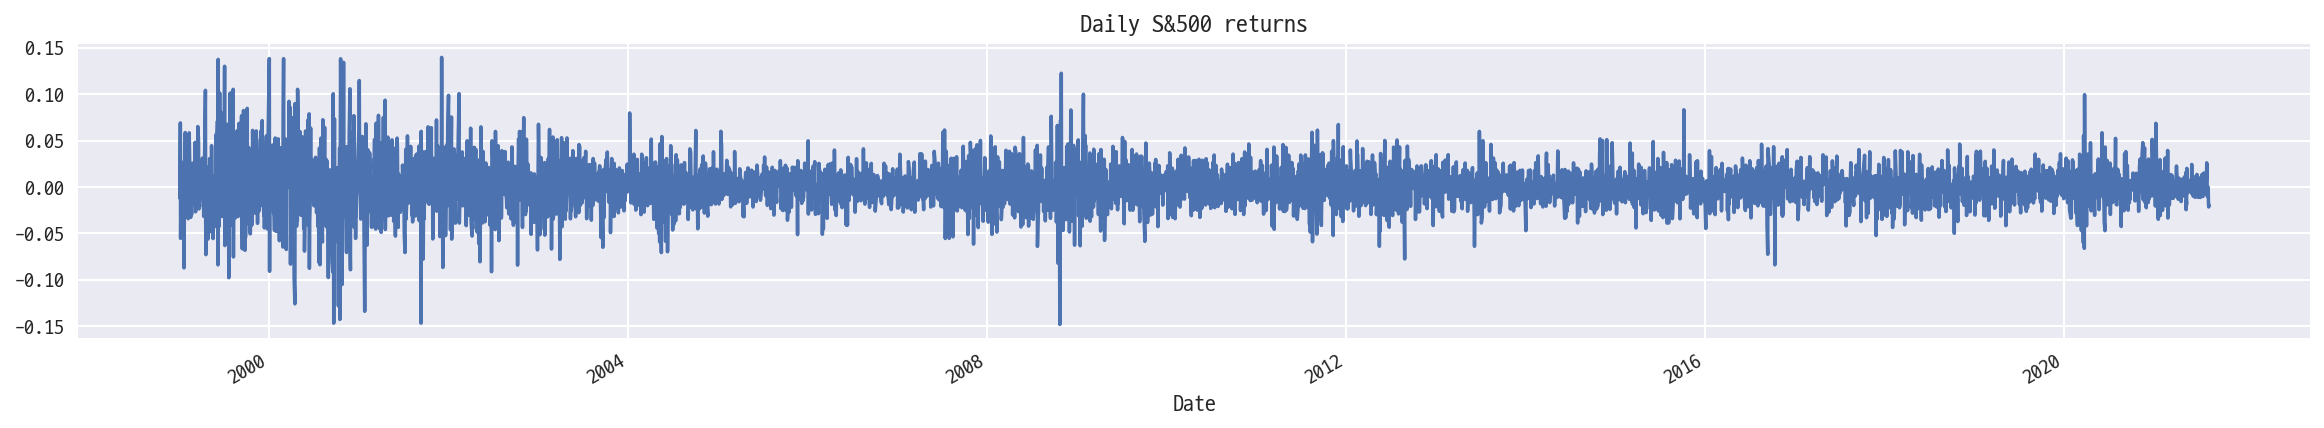

In [7]:
# Log 수익률을 도식화 한다.
df.log_rtn.plot(figsize=(20, 3), title='Daily S&500 returns')
plt.show()

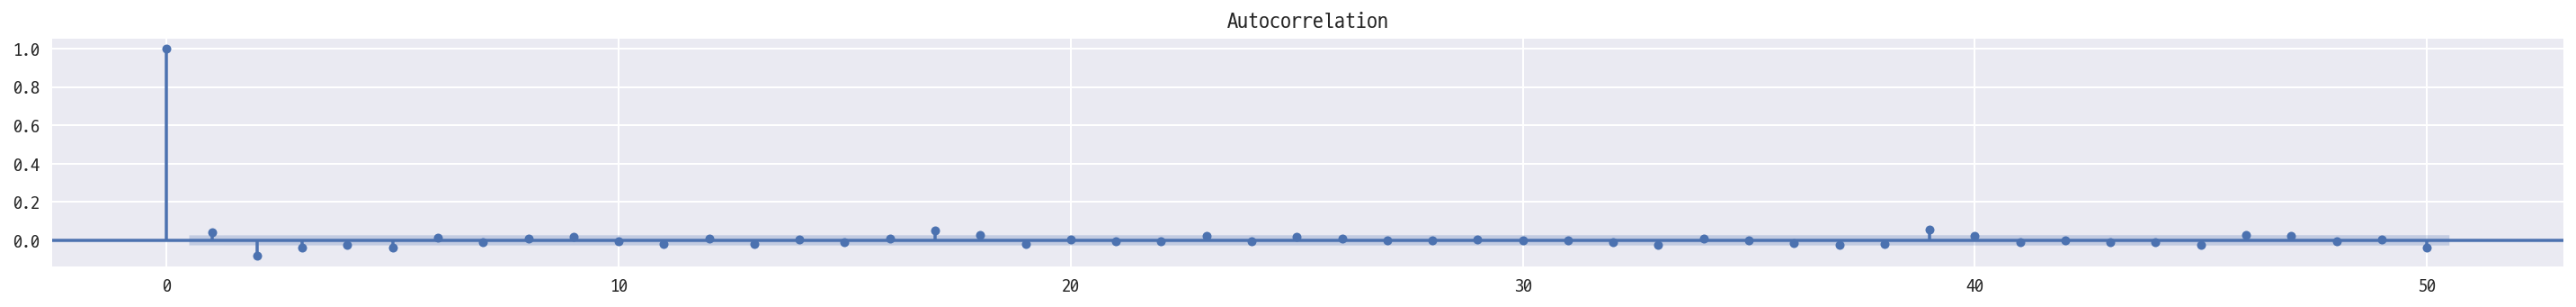

In [8]:
# 수익률과 자기 상관의 부재
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

# 상관관계 함수를 활용하여 그림을 그린다 
import statsmodels.tsa.api as smt
plt.rcParams['figure.figsize'] = (20.0, 2.5)
acf = smt.graphics.plot_acf(
    df.log_rtn, lags=N_LAGS, alpha = SIGNIFICANCE_LEVEL)
plt.tight_layout(); plt.show()
# 신뢰구간을 벗어나는 값은 몇개만 보인다 (귀무가설이 기각)
# 이를 근거로 Log 수익률 시계결은 자기 상관관계가 없음이 확인 됨

### **04 제곱 수익률과 절대 수익률의 ACF 분석**
ACF 도표를 만들어서 자기 상관관계를 분석 합니다
- 제곱과 절대 수익률에 대한 자기 상관관계값이 작고 감소함을 관찰 가능하다

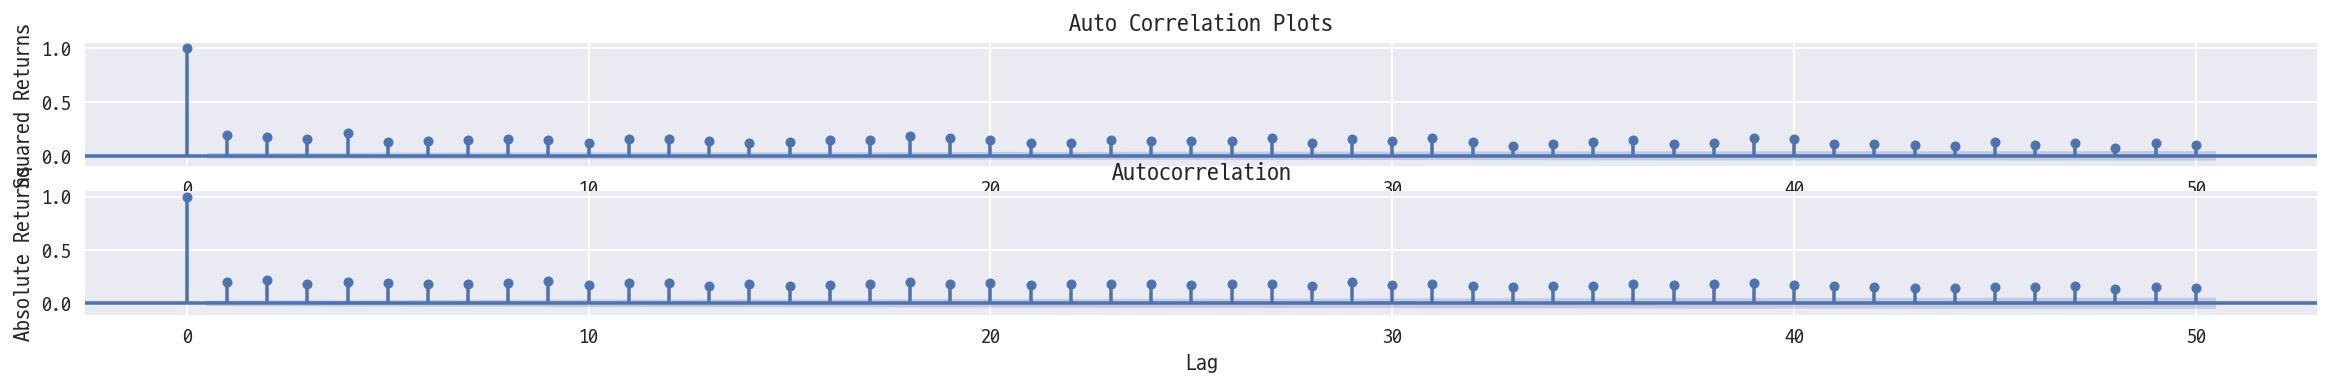

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(20, 2.5))
# 절대 수익률의 ACF 그래프를 그린다
smt.graphics.plot_acf(df.log_rtn ** 2, 
        lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title='Auto Correlation Plots', ylabel='Squared Returns')

# 제곱 수익률의 ACF 그래프를 그린다
smt.graphics.plot_acf(np.abs(df.log_rtn),
        lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel='Absolute Returns', xlabel='Lag')
plt.show()

### **05 레버리지 효과의 분석**
레버리지 효과 존재를 확인한다

In [10]:
# Log 수익률의 이동평균선 만들기 (20일선, 1년선)
df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std()
df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std()

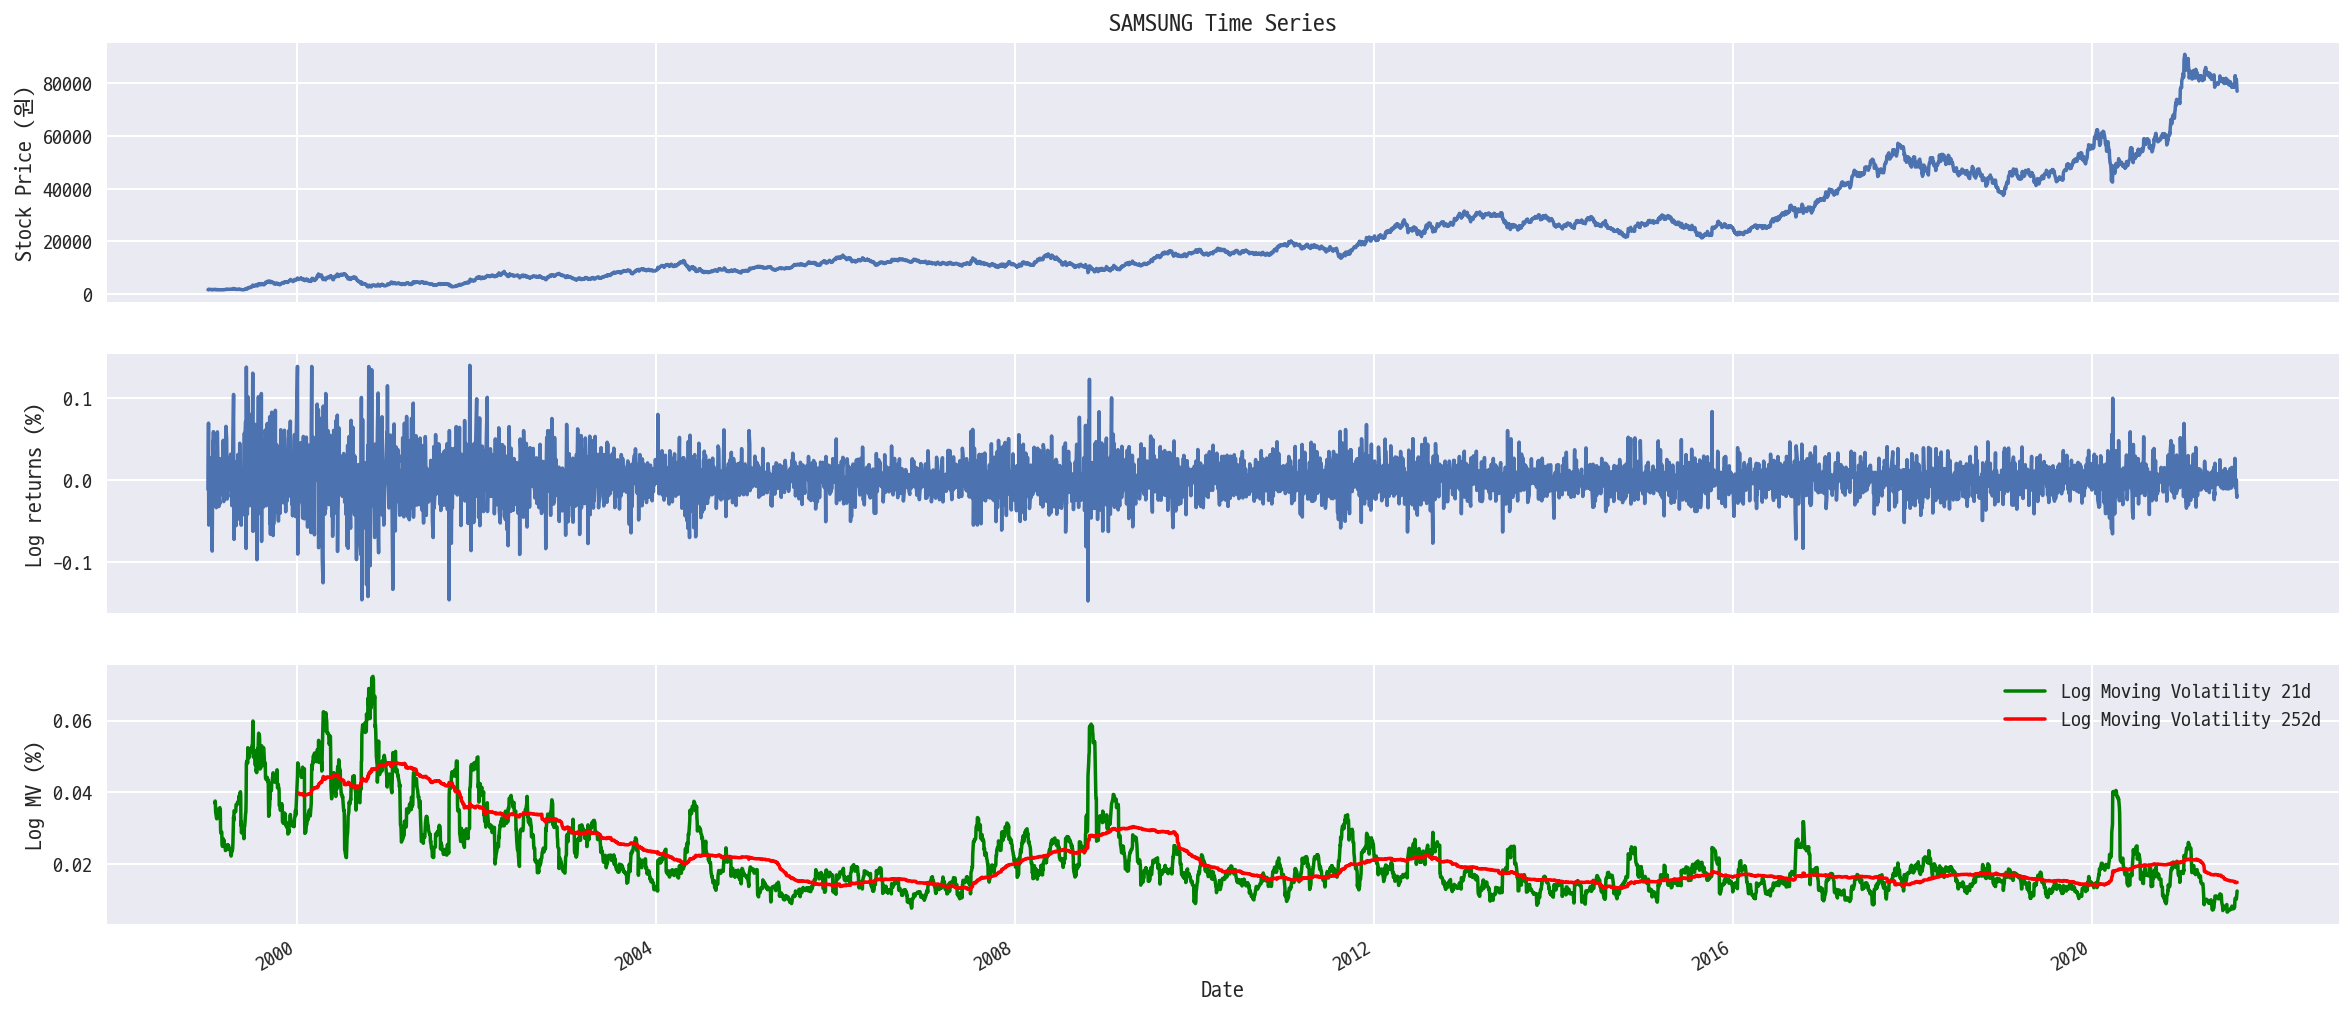

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(20,9), sharex=True)
df.adj_close.plot(ax=ax[0])
ax[0].set(title='SAMSUNG Time Series', ylabel='Stock Price (원)')

df.log_rtn.plot(ax=ax[1])
ax[1].set(ylabel='Log returns (%)')

df.moving_std_21.plot(ax=ax[2], color='g', label='Log Moving Volatility 21d')
df.moving_std_252.plot(ax=ax[2], color='r', label='Log Moving Volatility 252d')
ax[2].set(ylabel='Log MV (%)', xlabel='Date')
ax[2].legend(); plt.show()

### **06 레버리지 효과의 분석 2**
VIX 지수를 활용하여 전처리를 한다
```r
https://github.com/ranaroussi/yfinance
! pip install yfinance
```

In [12]:
DATA_FILENAME = 'data/stock-vix.pkl'
import pandas as pd
import yfinance as yf
try:
    df = pd.read_pickle(DATA_FILENAME)
except FileNotFoundError:
    df = yf.download(['^GSPC', '^VIX'], start='1999-01-01', end='2022-12-31', progress=False)
    df = df[['Adj Close']]
    df.columns = df.columns.droplevel(0)
    df = df.rename(columns={'^GSPC': 'sp500', '^VIX': 'vix'})
    df.to_pickle(DATA_FILENAME)
df.head(3)

,sp500,vix
Date,,
1998-12-31,1229.229980,24.420000
1999-01-04,1228.099976,26.170000
1999-01-05,1244.780029,24.459999


In [13]:
# 지수 데이터를 Log 수익률을 활용하여 계산 합니다.
# log 대신 단순 수익률의 백분율 변화를 사용해도 된다
df['log_rtn'] = np.log(df.sp500 / df.sp500.shift(1))
df['vol_rtn'] = np.log(df.vix / df.vix.shift(1))
df.dropna(how='any', axis=0, inplace=True)
corr_coeff = df.log_rtn.corr(df.vol_rtn)

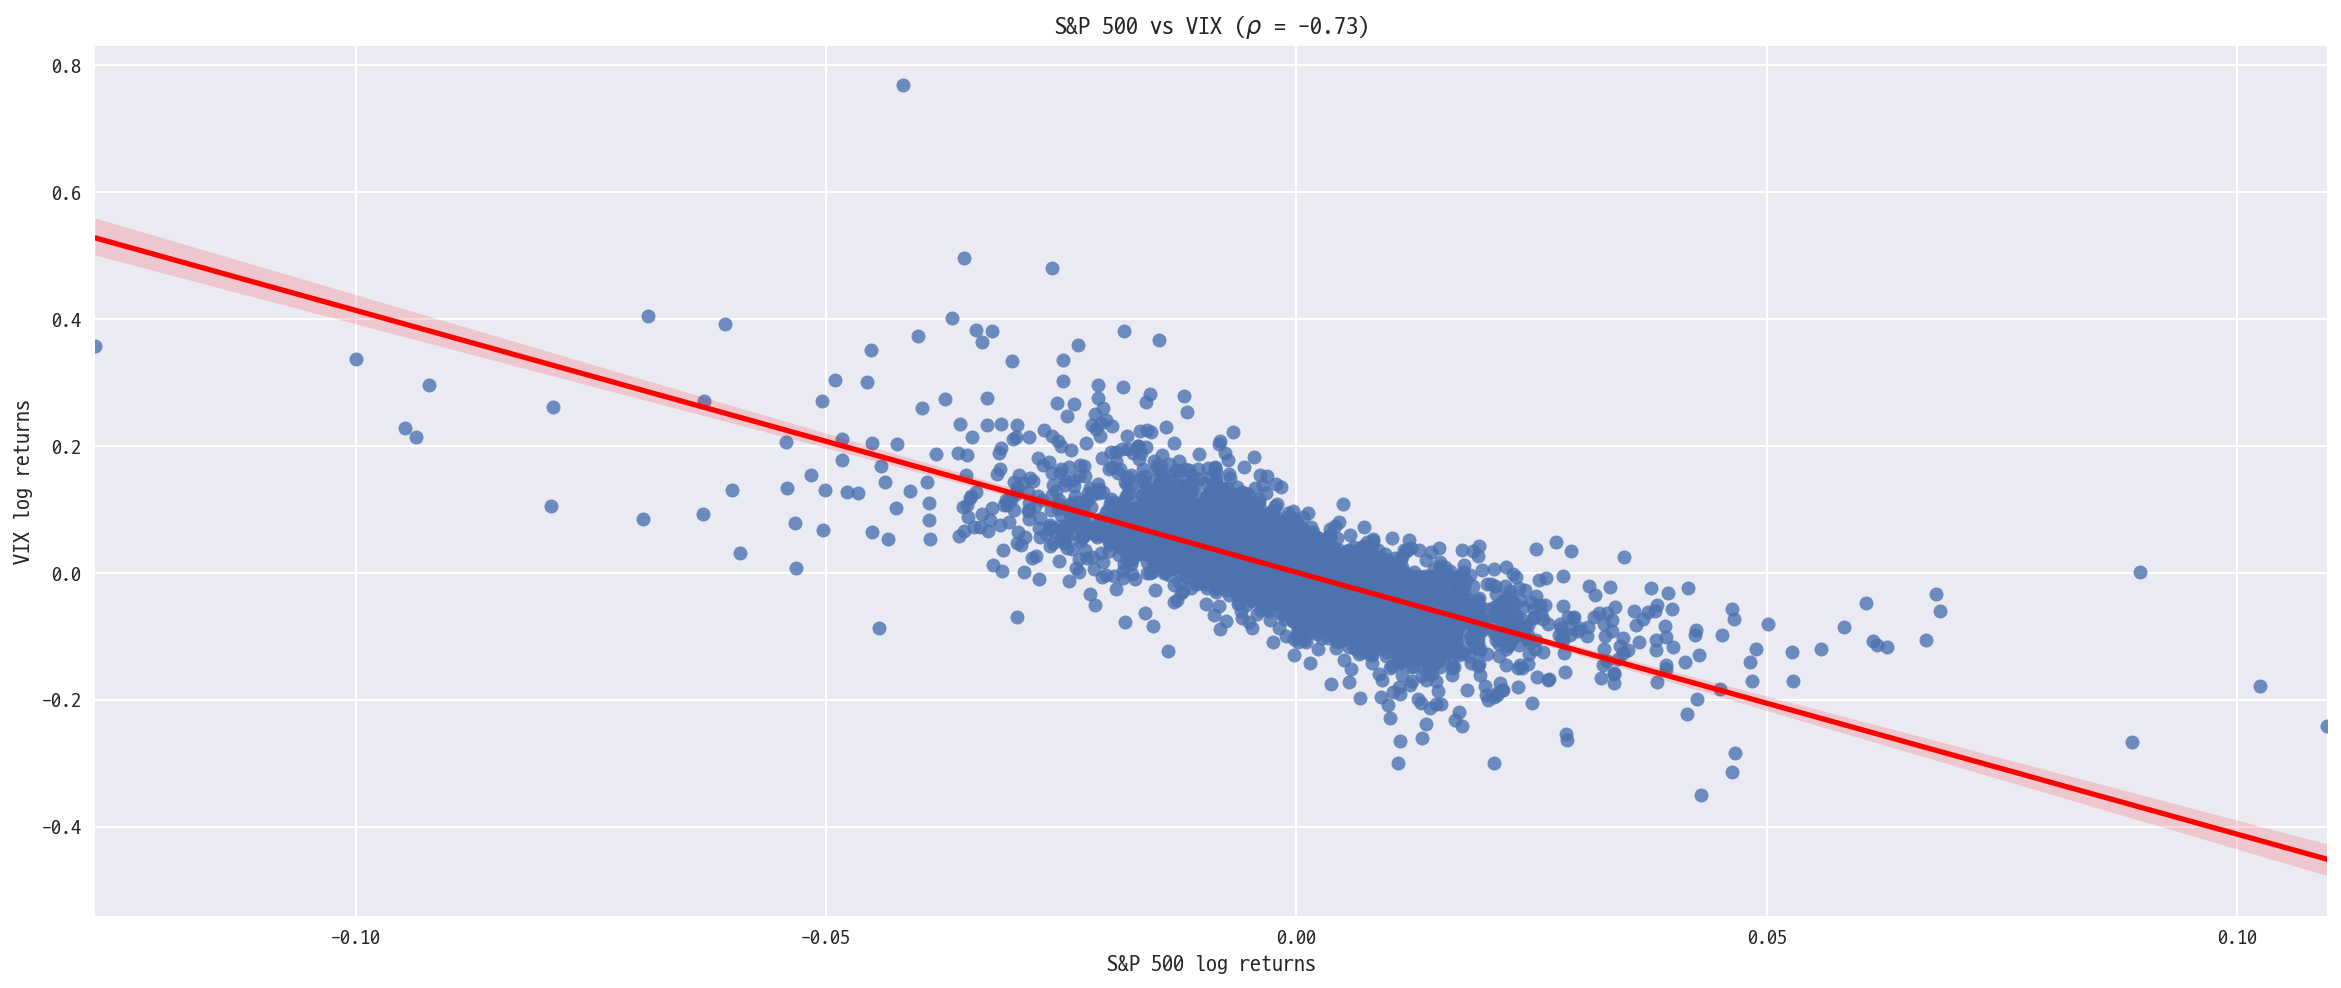

In [14]:
# Visualization
plt.rcParams['figure.figsize'] = (20.0, 8.0)
ax = sns.regplot(x='log_rtn', y='vol_rtn', data=df, line_kws={'color':'red'})
ax.set(title=f'S&P 500 vs VIX ($\\rho$ = {corr_coeff:.2f})', ylabel='VIX log returns', xlabel='S&P 500 log returns')
plt.show()